In [8]:
import pandas as pd
import time
import numpy as np
from enum import IntEnum
from datetime import datetime as dt
import os
import seaborn as sns
import xlsxwriter
from matplotlib import pyplot as plt
import swco
import metric as me
import feather
import k_mers_metric as kmm
from pathlib import Path

In [2]:
# Read all genes and process them tagging which specie are from
df_species = swco.read_all('../Data/Raw/Tables_Filtered_IK_format.xlsx')

In [3]:
df_species = pd.read_feather('../Data/Intermediate/annotation.feather')

df_species['Start'] = df_species['Start'].astype('int64')
df_species['Stop'] = df_species['Stop'].astype('int64')

In [4]:
# Create a data frame with the length of each scaffold for all the species
#df_scaffold_length = swco.df_scaffold_length(df_species)
df_scaffold_length = pd.read_csv('../Data/Intermediate/df_' + level + '_length.csv')
df_scaffold_length.head()

# For the new format of GFF files
#df_scaffold_length = (df_length[['Specie', 'Replicon Accession', 'Number of genes']]
#                    .rename(columns = {'Specie': 'species', 'Replicon Accession': 'scaffold', 'Number of genes': 'length'}))

,Specie,#Replicon Name,Replicon Accession,Number of genes,Start,Stop
0,Aadvark,MT,NC_002078.1,13,2744,15310
1,Aadvark,Un,NW_006921588.1,129,2349339,39525097
2,Aadvark,Un,NW_006921589.1,169,30547,38336954
3,Aadvark,Un,NW_006921590.1,77,719496,36587654
4,Aadvark,Un,NW_006921591.1,33,8315,35191965


In [5]:
# Create a data frame with the length of each scaffold for all the species
'''df_scaffold_length = (df_species[['Specie', '#Replicon Name', 'Replicon Accession', 'Gene', 'Start', 'Stop']]
                        .groupby(['Specie', '#Replicon Name', 'Replicon Accession'], as_index=False)
                        .agg({'Gene': 'count', 'Start': 'min', 'Stop': 'max'}))

df_scaffold_length.rename(columns={'Gene':'Number of genes'}, inplace=True)
df_scaffold_length.to_csv('../Data/Intermediate/df_scaffold_length.csv', index=False)
df_scaffold_length'''

"df_scaffold_length = (df_species[['Specie', '#Replicon Name', 'Replicon Accession', 'Gene', 'Start', 'Stop']]\n                        .groupby(['Specie', '#Replicon Name', 'Replicon Accession'], as_index=False)\n                        .agg({'Gene': 'count', 'Start': 'min', 'Stop': 'max'}))\n\ndf_scaffold_length.rename(columns={'Gene':'Number of genes'}, inplace=True)\ndf_scaffold_length.to_csv('../Data/Intermediate/df_scaffold_length.csv', index=False)\ndf_scaffold_length"

There will be two basic elements when comparing two scaffolds:
- Target sequence: it is our base and is compared versus all related scaffolds of different species 
- Query sequence: iterating between all related scaffolds of the query sequence  

Each sequence is based of two components: specie and scaffold.  
Related scaffolds are the ones which have more than a defined number (*k_threshold*) of common k_mers for an arbitrary *k*.  
For the moment, the query sequence is defined for human species which it will be iterating among all its scaffolds longer than *sca_length* genes.

If all vs. all species comparison is required, iterate for all species.

In [6]:
#df_k_mers = me.read_k_mers_prime('../Data/Intermediate/k_mers/Scaffold/')
df_k_mers = pd.read_feather('../Data/Intermediate/k_mers/Scaffold/df_k_mers_prime.feather')

In [ ]:
# When new GFF files comes
#df_k_mers = pd.read_feather('../Data/Intermediate/k_mers/processed/df_k_mers.feather')

In [ ]:
'''
# If we want to update the feather file
# Let's read the new k-mers from GFF files
import read_k_mers as rkm

# Path to the folder with the processed files
path = '../Data/Intermediate/k_mers/processed/'
data_list = rkm.process_folder(path)

# Convert the list of dictionaries into a single DataFrame, including the species and k columns
df_list = pd.concat([d['data'].assign(species_gcf_id=d['species_gcf_id'], k=d['k']) for d in data_list], ignore_index=True)
#df_list = pd.concat([d['data'] for d in data_list], ignore_index=True)
df_list = df_list[['species_gcf_id', 'k', 'k_mer', 'replicon_accession']].rename(columns={'replicon_accession': 'scaffold'})

# Create a column in the dataframe with the species name
file_species = rkm.map_species_to_file()
df_list['species'] = df_list['species_gcf_id'].map(file_species)

df_k_mers.to_feather('../Data/Intermediate/k_mers/processed/df_k_mers.feather')
'''
'''

In [ ]:
'''# When I have the new GFF files
k_mers_counter = pd.read_feather('../Data/Intermediate/k_mers/count_k_mers_scaffold.feather')

# For refreshing this file:
import count_k_mers as ckm
ckm.count_k_mers(df_list)'''

In [9]:
df_species.Start = df_species.Start.astype('int64')
df_species.Stop = df_species.Stop.astype('int64')

In [10]:
#accession_num_pairs = df_species.groupby(['Specie', 'Replicon Accession'], as_index=False).agg({'Start':'min', 'Stop':'max'})

In [11]:
# When the parameters are set up to [], all the species/scaffolds will be considered
# target species/scaffold refers the species we align against the query species/scaffold
def alignment(path='../Data/S_W_Intermediate/Scaffold/', target_species=[], target_scaffold=[], query_species=[], query_scaffold=[], k_threshold = 7, min_common = 3, df_k_mers = df_k_mers, df_scaffold_length = df_scaffold_length, df_species = df_species):

    # Create the folder to save the results
    # Change
    timestamp = dt.now().strftime('%Y%m%d_%H%M%S')
    print(timestamp)

    # Create a folder for the results and the images
    swco.create_folder(path + timestamp)
    swco.create_folder(path + timestamp + '/Images')

    # all vs. all -> implement post processing implementation
    for target_sp in target_species:

        # Select the target species scaffolds, and order them by length
        # Define the minimum gene length to consider a scaffold comparable
        min_sca_length = 50

        if not target_scaffold:
            df_target_sca = (df_scaffold_length.loc[(df_scaffold_length['Specie'].str.contains(target_sp, case=False, regex=True)) & (df_scaffold_length['Number of genes'] > min_sca_length)]
                            .sort_values('Number of genes', ascending = False)
                            .reset_index()
                            ['Replicon Accession'])
        else:
            df_target_sca = target_scaffold
        #df_target_sca = df_target_sca.iloc[:3]

        # For visualization purposes, have each alignment information together, in a single array
        # This dataframe will have the starting and ending positions of the alignment in the query and target scaffolds
        # Moreover, it will have the match percentage of the alignment
        # Finally, it will have the alignment identifier itself
        blocks = []

        # Counter per alignment done
        align_counter = 0

        # For each scaffold of the target specie, the most similar scaffolds of the different species are listed
        
        
        for target_sca in df_target_sca:
        
            # For just one target scaffold (for testing purposes)
            #target_sca = df_target_sca[15]

            target_name = target_sp + '_' + target_sca
            target_len = swco.scaffold_length(target_sp, target_sca, df_scaffold_length)

            print(target_name)

            # List the species_scaffold which have common k_mers with the query scaffold
            # Define parameters
            k_threshold = 7 # must be prime, if we have load only the prime k_mers
            min_common = 3 # minimum number of common k_mers to consider a scaffold as a candidate
            query_candidates = swco.match_scaffold(k_threshold, target_sp, target_sca, min_common, df_k_mers)

            # Filter the query candidates by specie and scaffold from the input parameters list
            if query_species:
                query_candidates = query_candidates.loc[query_candidates['Specie'].str.lower().isin([x.lower() for x in query_species])]
                if query_scaffold:
                    query_candidates = query_candidates.loc[query_candidates['Scaffold'].str.lower().isin([x.lower() for x in query_scaffold])]
                    
            # If there are no candidates, continue with the next scaffold
            # change
            if query_candidates.empty:  # .loc[query_candidates['Specie'].str.contains('gorilla', case=False)]
                print('No candidates for ' + target_name)
                continue

            # Order the scaffolds per similiraty, applying the metric between each other
            df_scaffold_cand = []
            # This process here is quite slow, when computing metric
            for query_name in query_candidates['Specie_Scaffold']:

                query_sp, query_sca = query_name.split('_', 1)

                query_len = swco.scaffold_length(query_sp, query_sca, df_scaffold_length)
                current = { 
                            'Specie': query_sp,
                            'Scaffold': query_sca,
                            # Metric computation takes too long -> needs to search which k_mers are common and which belong to each scaffold
                            'Ratio': me.metric_comp(target_name, query_name, df_k_mers, target_len, query_len)
                        }
                print(current)

                df_scaffold_cand.append(current)
            df_scaffold_cand = pd.DataFrame(df_scaffold_cand).sort_values(['Specie', 'Ratio'], ascending=[True, False])
            
            # Filter to keep only the relevant scaffolds for this alignment
            #k_mers_counter_query = k_mers_counter.merge(query_candidates, left_on = ['species', 'scaffold'], right_on = ['Specie', 'Scaffold'])

            #df_scaffold_cand = kmm.k_mers_to_metric(origin, level='scaffold', k_mers_counter_query, df_scaffold_length, df_k_mers)

            
            # Apply Smith-Waterman algorithm to other species scaffolds candidates

            # Load the target scaffold genes
            target = df_species[(df_species['Specie'].str.contains(target_sp, case=False, regex=True)) & (df_species['Replicon Accession'].str.contains(target_sca, case=False, regex=True))]

            # To check the precious specie name in the next iteration, we need to store values
            query_sp_old = ''
            target_or = target

            # Open a workbook per each target scaffold
            writer = pd.ExcelWriter(path + timestamp + '/'  + target_sp + '_' + target_sca + '.xlsx', engine = 'xlsxwriter')

            # Define the parameters for later on write them on the results
            params = []
            params = pd.DataFrame({
                'Description': ['', 'Parameters', 'Match', 'Mismatch', 'First gap', 'Second gap'], 
                'Value': ['', '', swco.Score.MATCH, swco.Score.MISMATCH, swco.Score.FIRST_GAP, swco.Score.CONS_GAP]})

            results = pd.DataFrame()
            align_species = pd.DataFrame()

            # Remove Ratio filter when computing for final results -> performance might be worse & might appear some errors, e.g., human_NC_000008.11 vs. Anolis 
            # Go through the list of scaffolds candidates to apply Smith-Waterman algorithm
            for query_sp, query_sca in df_scaffold_cand[['Specie', 'Scaffold']].values:
                
                # Check if the specie is the same as before 
                if query_sp != query_sp_old:
                    target = target_or            

                    # Write the results of the previous specie
                    # Observe query_name has still not updated
                    # We can differentiate each block of alignments by the query scaffold name
                    if not align_species.empty:
                        swco.write_alignment(align_species, query_sp, query_sca, writer)

                # To check the precious specie name in the next iteration
                query_sp_old = query_sp

                query = df_species.loc[(df_species['Specie'] == query_sp) & (df_species['Replicon Accession'] == query_sca)]
                query_name = query_sp + '_' + query_sca

                print(target_sp + '_' + target_sca + ' vs. ' + query_name)

                # Increase the counter
                align_counter += 1

                # Executing the Smith Waterman local alignment algorithm
                # Initialize variables
                aligned_query = []
                aligned_target = []
                index_query = []
                index_target = []
                matrix = [[]]

                tic = time.perf_counter()
                aligned_target, aligned_query, index_target, index_query, max_score, max_index, max_i, max_j, matrix = swco.smith_waterman(target, query)
                toc = time.perf_counter()

                # Time
                d = toc - tic
                print('S-W Computed in %s'%time.strftime('%H:%M:%S', time.gmtime(d)))
                
                tic = time.perf_counter()

                # Check if the alignment is empty
                if not aligned_target:
                    print('No alignment found')
                    continue

                # Smith Waterman algorithm returns a target and a query aligned sequences. Align them to be able to represent them in a table
                # Moreover, merge the aligned sequences with the relevant information from the original sequences
                align = pd.DataFrame()
                align = swco.merge(target, query, aligned_target, index_target, aligned_query, index_query)

                # Look for the genes which have been duplicated
                align = swco.duplicate(align)

                # Keep the results of the alignement per species
                align_species = pd.concat([align_species, align])

                toc = time.perf_counter()

                d = toc-tic
                print('Postprocessed in %s' %time.strftime('%H:%M:%S', time.gmtime(d)))

                tic = time.perf_counter()

                # Keep the values of the aligned indeces
                index_query_no_gaps = []
                index_target_no_gaps = []

                # Remove gaps
                index_query_no_gaps = list(filter(lambda c: c!= '-', index_query))
                index_target_no_gaps = list(filter(lambda c: c!= '-', index_target))

                # Convert their elements to integers
                index_query_no_gaps = list(map(int, index_query_no_gaps))
                index_target_no_gaps = list(map(int, index_target_no_gaps))

                # Summary results of the alignement: include some information + parameters + KPIs
                summary = []
                summary = pd.DataFrame({
                    'Description' : ['Target Sequence', 'Length Target Sequence', 'Query Sequence', 'Length Query Sequence', 'Score', '',
                                        'Aligned Target Sequence initial position', 'Aligned Target Sequence final position', 'Aligned Target Sequence length', '',
                                        'Aligned Query Sequence initial position', 'Aligned Query Sequence final position', 'Aligned Query Sequence length'],
                    'Value': [target_name, len(target), query_name, len(query), df_scaffold_cand.loc[(df_scaffold_cand['Specie'].str.contains(query_sp)) & (df_scaffold_cand['Scaffold'].str.contains(query_sca)), 'Ratio'].values, '',
                                    index_target_no_gaps[0], index_target_no_gaps[-1], index_target_no_gaps[-1] - index_target_no_gaps[0], '',
                                    index_query_no_gaps[0], index_query_no_gaps[-1], index_query_no_gaps[-1] - index_query_no_gaps[0]]
                })

                summary = pd.concat([summary, params])

                aligned_query_no_gaps = []
                aligned_target_no_gaps = []
                aligned_query_no_gaps = list(filter(lambda c: c!= '-', aligned_query))
                aligned_target_no_gaps = list(filter(lambda c: c!= '-', aligned_target)) 

                #KPIs
                perc_align_query = len(aligned_query_no_gaps) / len(query)
                perc_align_target = len(aligned_target_no_gaps) / len(target)

                kpi = []
                kpi = pd.DataFrame({
                    'Description': ['','KPIs','% Covered Target sequence', '% Covered Scaffold', 'Number of consecutive genes', ''], #include where duplicates occur
                    'Value': ['','', perc_align_target, perc_align_query, align.shape[0], '']
                })

                result_perc = align.groupby('Result').count() / align.shape[0]
                result_perc = result_perc.reset_index().iloc[:,[0,1]]
                result_perc.rename(columns = {
                                    'Result':'Description', 
                                    'Target Sequence Original Position': 'Value'},
                                    inplace=True)

                summary = pd.concat([summary, kpi, result_perc]) # summary.append(kpi)

                # Keep the alignment results for alignment visualization
                # We want to keep the starting and stopping positions of the alignment in the target and query sequences
                # target_sca is introduced in both of them in order to aggrupate them in the plot
                # To report the match percentage, the value of the match is taken from the result_perc dataframe
                # Not always we have a match, so we need to check if the value is present and keep it in a variable
                # If not, we assign a 0 value
                if result_perc.loc[result_perc['Description'] == 'Match', 'Value'].empty:
                    match_perc = 0
                else:
                    match_perc = result_perc.loc[result_perc['Description'] == 'Match', 'Value'].values[0]

                # One with the target and one with the query ifnormation
                blocks.append([target_name, target_sca, align_counter, min(align['Target Start'].astype('float')), max(align['Target Stop'].astype('float')), match_perc])
                blocks.append([query_name, target_sca, align_counter, min(align['Query Start'].astype('float')), max(align['Query Stop'].astype('float')), match_perc])

                # Write
                summary.to_excel(writer, sheet_name = 'Sum_' + query_name, index = False, header=False)

                # Keep a track of the results among all the scaffolds
                actual_results = pd.DataFrame(data = {
                                                'Target Specie':[target_sp], 
                                                'Target Scaffold': [target_sca], 
                                                'Query Specie':[query_sp], 
                                                'Query Scaffold': [query_sca], 
                                                '% Covered Target sequence': [perc_align_target], 
                                                '% Covered Accession': [perc_align_query], 
                                                'Number of consecutive genes': [align.shape[0]]
                                            })
                                            
                results = pd.concat([results, actual_results])
                
                # Heatmap of the alignment
                heatmap = sns.heatmap(matrix)
                plt.title('Heatmap of ' + target_name + ' vs. ' + query_name, fontsize = 12)
                plt.savefig(path + timestamp + '/Images/' + query_name + '.png')
                plt.clf()

                workbook  = writer.book
                worksheet = writer.sheets['Sum_' + query_name]
                worksheet.insert_image('H2', path + timestamp + '/Images/' + query_name + '.png')
                
                toc = time.perf_counter()

                d = toc-tic
                print('Saved in %s'%time.strftime('%H:%M:%S', time.gmtime(d)))
                
                # Remove match parts, when we have the same specie
                prev = []
                after = []
                prev = target.loc[target['index'].astype('int') < index_target_no_gaps[0] + 1]
                after = target.loc[index_target_no_gaps[-1] - 1 < target['index'].astype('int')]

                target = pd.concat([prev, after])

                # Clean variables
                del heatmap, perc_align_target, perc_align_query, result_perc, match_perc
            # End of the loop

            # Write the last alignment 
            swco.write_alignment(align_species, query_sp, query_sca, writer)

            results.to_excel(writer, sheet_name = 'Results', index = False)
            writer.sheets['Results'].activate()
            writer.close()   

    # Before saving blocks, let's add column names to the list
    blocks = pd.DataFrame(blocks)
    blocks.columns = ['species_scaffold', 'target_scaffold', 'alignment_id', 'start', 'stop', 'match_perc']
    blocks.to_csv(path + timestamp + '/blocks.csv', index = False)

    # Useful, e.g., human_NC_000001.11 vs. Aadvark
    # For NC_000001.11 (longest human), more than 6 minutes
    # 45 mins human vs gorilla

In [12]:
alignment(target_species=['gorilla'], query_species=['human'])

20230402_182505
Folder created at ../Data/S_W_Intermediate/Scaffold/20230402_182505
Folder created at ../Data/S_W_Intermediate/Scaffold/20230402_182505/Images
gorilla_NC_018424.2
{'Specie': 'Human', 'Scaffold': 'NC_000001.11', 'Ratio': 0.9999351287616962}
gorilla_NC_018424.2 vs. Human_NC_000001.11
S-W Computed in 00:07:15
Postprocessed in 00:00:00
Saved in 00:00:10
gorilla_NC_018429.2
{'Specie': 'Human', 'Scaffold': 'NC_000005.10', 'Ratio': 0.9987345979002227}
gorilla_NC_018429.2 vs. Human_NC_000005.10
S-W Computed in 00:01:44
Postprocessed in 00:00:00
Saved in 00:00:02
gorilla_NC_018443.2
{'Specie': 'Human', 'Scaffold': 'NC_000019.10', 'Ratio': 0.9998153269513051}
{'Specie': 'Human', 'Scaffold': 'NW_014040929.1', 'Ratio': 1.0}
gorilla_NC_018443.2 vs. Human_NW_014040929.1
S-W Computed in 00:00:01
Postprocessed in 00:00:00
Saved in 00:00:01
gorilla_NC_018443.2 vs. Human_NC_000019.10
S-W Computed in 00:02:51
Postprocessed in 00:00:00
Saved in 00:00:03
gorilla_NC_018435.2
{'Specie': 'Huma

<Figure size 640x480 with 0 Axes>

In [14]:
results.to_excel(writer, sheet_name = 'Results', index = False)
writer.sheets['Results'].activate()
writer.save()   

NameError: name 'results' is not defined

0

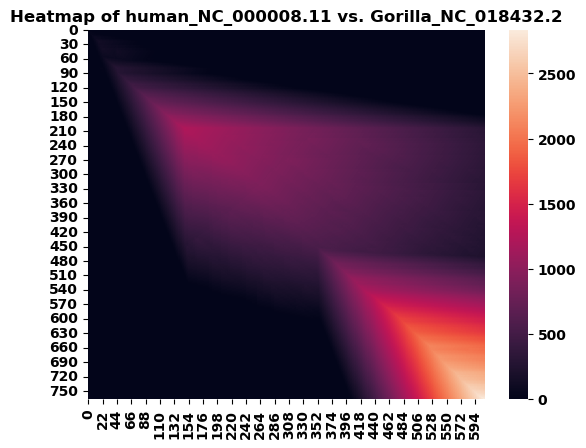

In [ ]:
heatmap = sns.heatmap(matrix)
plt.title('Heatmap of ' + target_name + ' vs. ' + query_name, fontsize = 12)
plt.savefig(path + 'Images/' + timestamp + '_' + query_name + '.png')
#plt.clf()

workbook  = writer.book
worksheet = writer.sheets['Sum_' + query_name]
worksheet.insert_image('H2', path + 'Images/' + timestamp + '_' + query_name + '.png')

In [ ]:
query.head()

,index,#Replicon Name,Replicon Accession,Start,Stop,Strand,GeneID,Locus,Protein product,Length,Protein name,Unnamed: 10,Specie,Locus tag,Geneid,Gene_non_or,Gene,Specie_Scaffold
498189,659539,X,NC_018447.2,49013,59450,+,101146421,PLCXD1,XP_004063765.2,276,PREDICTED: PI-PLC X domain-containing protein ...,nan,Gorilla,nan,nan,PLCXD,PLCXD+,Gorilla_NC_018447.2
498190,659540,X,NC_018447.2,68844,83191,-,101146761,GTPBP6,XP_018874803.1,304,"PREDICTED: putative GTP-binding protein 6, par...",nan,Gorilla,nan,nan,GTPBP,GTPBP-,Gorilla_NC_018447.2
498191,659541,X,NC_018447.2,88854,183847,-,101147502,PPP2R3B,XP_018874798.1,805,PREDICTED: serine/threonine-protein phosphatas...,nan,Gorilla,nan,nan,PPP,PPP-,Gorilla_NC_018447.2
498192,659542,X,NC_018447.2,91635,183847,-,101147502,PPP2R3B,XP_018874794.1,761,PREDICTED: serine/threonine-protein phosphatas...,nan,Gorilla,nan,nan,PPP,PPP-,Gorilla_NC_018447.2
498193,659544,X,NC_018447.2,483142,500183,+,101147858,SHOX,XP_004063767.1,292,PREDICTED: short stature homeobox protein,nan,Gorilla,nan,nan,SHOX,SHOX+,Gorilla_NC_018447.2


In [ ]:
(df_species.loc[df_species['Specie'].str.contains('gorilla', case=False), ['Start', 'Stop', 'Replicon Accession']]
        .groupby('Replicon Accession', as_index=False)
        .agg({
                'Start':'min',
                'Stop':'max'})
        .sort_values(by=['Start'], ascending=False))

,Replicon Accession,Start,Stop
74,NW_017509898.1,9905,37161
100,NW_017518990.1,977,8531
127,NW_017534014.1,956,4311
43,NW_017499383.1,903,2278
73,NW_017509646.1,899,1994
...,...,...,...
23,NC_018446.2,10005840,9995645
4,NC_018427.2,10002053,9997606
20,NC_018443.2,10001691,9953418
3,NC_018426.2,100014491,99903197
